In [15]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
from facenet_pytorch import InceptionResnetV1
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

### Load FaceNet model

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
facenet = InceptionResnetV1(pretrained="vggface2").eval().to(device)

### Convert images to tensor

In [17]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

### Extract embedding

In [18]:
def extract_embedding(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        embedding = facenet(img_tensor).cpu().numpy().flatten()

    return embedding

### Load dataset and extract embedding

In [19]:
dataset_path = "dataset/students/train"  # Chỉ dùng ảnh trong train để train model phân loại

X = []  # Chứa embeddings
y = []  # Chứa nhãn (mã sinh viên)

for student_id in os.listdir(dataset_path):
    student_folder = os.path.join(dataset_path, student_id)
    if not os.path.isdir(student_folder):
        continue  # Bỏ qua nếu không phải thư mục

    for img_file in os.listdir(student_folder):
        img_path = os.path.join(student_folder, img_file)
        embedding = extract_embedding(img_path)

        X.append(embedding)  # Lưu embedding
        y.append(student_id)  # Lưu nhãn

X = np.array(X)
y = np.array(y)

# Chuyển nhãn (student_id) sang dạng số
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

### Train SVM

In [20]:
classifier = SVC(kernel="linear", C=10, probability=True)  # SVM tuyến tính
classifier.fit(X, y_encoded)

SVC(C=10, kernel='linear', probability=True)

### Evaluate

In [21]:
from sklearn.metrics import accuracy_score

# Dự đoán trên tập train
y_train_pred = classifier.predict(X)

# Đánh giá độ chính xác
train_acc = accuracy_score(y_encoded, y_train_pred)
print(f"🎯 Train Accuracy: {train_acc:.4f}")

🎯 Train Accuracy: 1.0000


### Predict

In [22]:
# Ảnh cần nhận diện
test_img_path = "dataset/students/test/HE180059/aug_1.jpg"

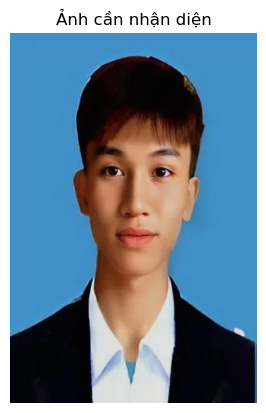

In [23]:
# Đọc ảnh
img = cv2.imread(test_img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Hiển thị ảnh
plt.imshow(img)
plt.axis("off")
plt.title("Ảnh cần nhận diện")
plt.show()


In [24]:
# Trích xuất embedding từ ảnh mới
embedding = extract_embedding(test_img_path).reshape(1, -1)
embedding.shape

(1, 512)

Text(0.5, 1.0, 'Embedding của ảnh test')

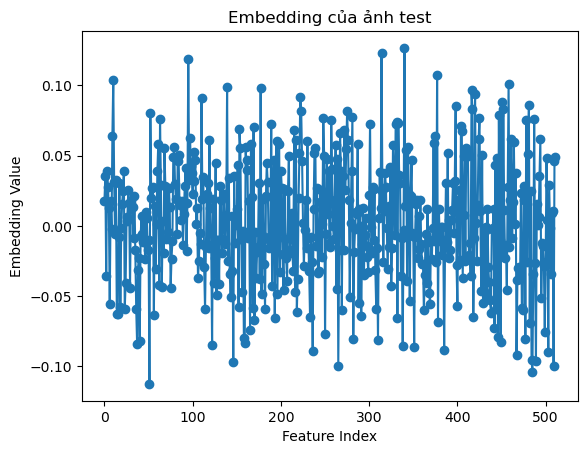

In [25]:
plt.plot(np.arange(embedding.shape[1]), embedding.flatten(), marker="o", linestyle="-")
plt.xlabel("Feature Index")
plt.ylabel("Embedding Value")
plt.title("Embedding của ảnh test")

In [26]:
predicted_label = classifier.predict(embedding)[0]
predicted_student_id = label_encoder.inverse_transform([predicted_label])[0]

print(f"Dự đoán: {predicted_student_id}")

Dự đoán: HE180059


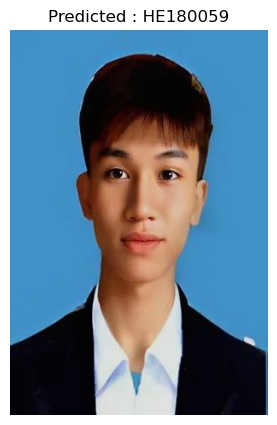

In [27]:
img = cv2.imread(test_img_path)

# Hiển thị ảnh có nhãn dự đoán
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title(f"Predicted : {predicted_student_id}")
plt.show()

### Dump model

In [28]:
import joblib

joblib.dump(classifier, "models/face_classifier.pkl")
joblib.dump(label_encoder, "models/label_encoder.pkl")

['models/label_encoder.pkl']